Hw3 Problem2 - Jaee Oh

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

Decision Tree using binary split.

In [144]:
def entropy(probability):
    result = 0.0
    if probability != []: # If probability is not empty.
        for p in probability:
            if p != 0:
                result -= p * np.log2(p)
    return result

def gini(probability):
    result = 1
    if probability != []: # If probability is not empty.
        for p in probability:
            result -= p**2
    return result

def findProbability(df, target, target_value):    
    # Initialzation
    n_total = df.shape[0]
    probability = []

    if n_total != 0:
        cnt = df[target].value_counts()
        for i in cnt.index:
            probability.append(cnt[i]/n_total)
    return probability

def findSplitPoint(df, attr_name, split_point):
    df_low = df[df[attr_name] < split_point]
    df_high = df[df[attr_name] >= split_point]
    return df_low, df_high

def findGiniChild(df, attr_name, split_point, target, target_value):
    df_low, df_high = findSplitPoint(df, attr_name, split_point)

    n_total = df.shape[0]
    n_low = df_low.shape[0]
    n_high = df_high.shape[0]

    prob_low = findProbability(df_low, target, target_value)
    prob_high = findProbability(df_high, target, target_value)

    gini_child = n_low/n_total * gini(prob_low) + n_high/n_total * gini(prob_high)
    return gini_child

def findMinGiniChild(df, attr_name, target, target_value):
    df_sort = df.sort_values(by=attr_name)
    split_point = df_sort[attr_name].unique()
    split_point = np.append(split_point, split_point[-1]+10)

    gini_list = []
    for i in range(len(split_point)):
        gini_list.append(findGiniChild(df_sort, attr_name, split_point[i], target, target_value))
    min_index = np.argmin(gini_list)
    return gini_list[min_index], split_point[min_index]

def findMinGiniAttr(df, target, target_value):
    gini_list = []
    attr_split = []
    split_point_min = []
    for attr_name in df.columns:
        if attr_name is not target:
            gini_attr, split_point = findMinGiniChild(df, attr_name, target, target_value)
            gini_list.append(gini_attr)
            split_point_min.append(split_point)
            attr_split.append(attr_name)
    min_index = np.argmin(gini_list)
    return attr_split[min_index], split_point_min[min_index], gini_list[min_index]

class Node:
    def __init__(self, df, target, target_names=None):
        self.df = df # df belonging to the node.
        self.target = target # Target attribute/column.
        self.target_labels = list(set(df[target])) # Nomerical labels of the target.
        self.target_names = target_names # Actual names of the labels of the target, if exist.
        self.columns = df.columns.to_list() # Attribues/Columns of the node/df.
        self.attr_split = None # Criteria for spliting the node.
        self.split_point = None # Split point for the binary split.
        self.gini = None # Gini index (min) of the node.
        self.left = None # Left child node.
        self.right = None # Right child node.
        self.check = True # If the node has child.
        self.sample = df.shape[0] # Number of samples.

    def findCondition(self):
        if self.check is True:
            self.attr_split, self.split_point, self.gini = findMinGiniAttr(self.df, self.target, self.target_labels)

    def findChildNode(self):
        if self.check is True:
            df_low, df_high = findSplitPoint(self.df, self.attr_split, self.split_point)

            self.left = Node(df_low, self.target, target_names=self.target_names)
            self.right = Node(df_high, self.target, target_names=self.target_names)

    # Methods to check if the child nodes should continue being split.
    def checkLeftChild(self):
        check = 0
        if self.left is not None:
            check += len(self.left.df['target'].unique()) - 1
        if check == 0:
            self.left.check = False
        return check
    
    def checkRightChild(self):
        check = 0
        if self.right is not None:
            check += len(self.right.df['target'].unique()) - 1
        if check == 0:
            self.right.check = False
        return check
    
def decision_tree(df, target, target_names, depth=3):
    tree =  [[] for _ in range(depth + 1)]
    tree[0].append(Node(df, target, target_names)) # Create the root node.

    for i in range(depth):
        for node in tree[i]:
            if node.check is True:
                node.findCondition()
                node.findChildNode()
                node.checkLeftChild()
                node.checkRightChild()
                tree[i + 1].append(node.left)
                tree[i + 1].append(node.right)
    return tree

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

tree = decision_tree(df, 'target', iris.target_names, depth=3)

i = 0
for item in tree:
    print(f"{i}th depth nodes:")
    i += 1
    for node in item:
        print(f"    Condition: {node.attr_split} < {node.split_point}; gini = {node.gini}; sample = {node.sample}")

0th depth nodes:
    Condition: petal length (cm) < 3.0; gini = 0.3333333333333333; sample = 150
1th depth nodes:
    Condition: None < None; gini = None; sample = 50
    Condition: petal width (cm) < 1.8; gini = 0.11030595813204509; sample = 100
2th depth nodes:
    Condition: petal length (cm) < 5.0; gini = 0.0856481481481482; sample = 54
    Condition: petal length (cm) < 4.9; gini = 0.028985507246376812; sample = 46
3th depth nodes:
    Condition: None < None; gini = None; sample = 48
    Condition: None < None; gini = None; sample = 6
    Condition: None < None; gini = None; sample = 3
    Condition: None < None; gini = None; sample = 43


Decision tree using scikit-learn without test/train split for comparison with the algorithm above.

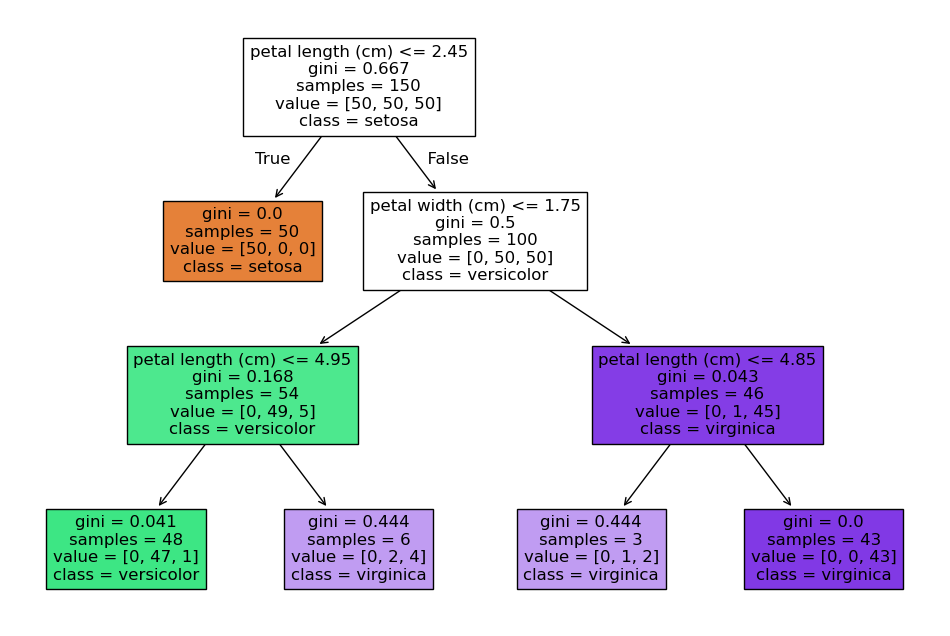

In [145]:
iris = load_iris()
X = iris.data
y = iris.target

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(max_depth=3, random_state=42)

model.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()